# CUDA performace against number of threads per block

In [1]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [2]:
using BenchmarkTools

import CUDA

In [3]:
function calculate_normal_velocity_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, threads) threads=threads maxregs=maxregs calculate_normal_velocity_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityTendency,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.cellsOnEdge,
                                                                        mpasOcean.nEdgesOnEdge,
                                                                        mpasOcean.edgesOnEdge,
                                                                        mpasOcean.weightsOnEdge,
                                                                        mpasOcean.fEdge,
                                                                        mpasOcean.dcEdge,
                                                                        mpasOcean.gravity)
end


calculate_normal_velocity_tendency_cuda_threadcount! (generic function with 1 method)

In [4]:
function update_normal_velocity_by_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, threads) threads=threads maxregs=maxregs update_normal_velocity_by_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.dt,
                                                                        mpasOcean.normalVelocityTendency)
end


update_normal_velocity_by_tendency_cuda_threadcount! (generic function with 1 method)

In [5]:
function calculate_ssh_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nCells, threads) threads=threads maxregs=maxregs calculate_ssh_tendency_cuda_kernel!(
                                                                        mpasOcean.nCells,
                                                                        mpasOcean.sshTendency,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.bottomDepth,
                                                                        mpasOcean.nEdgesOnCell,
                                                                        mpasOcean.edgesOnCell,
                                                                        mpasOcean.cellsOnCell,
                                                                        mpasOcean.areaCell,
                                                                        mpasOcean.edgeSignOnCell,
                                                                        mpasOcean.dvEdge)
end


calculate_ssh_tendency_cuda_threadcount! (generic function with 1 method)

In [6]:
function update_ssh_by_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nCells, threads) threads=threads maxregs=maxregs update_ssh_by_tendency_cuda_kernel!(
                                                                        mpasOcean.nCells,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.dt,
                                                                        mpasOcean.sshTendency)
end


update_ssh_by_tendency_cuda_threadcount! (generic function with 1 method)

In [7]:
function forward_backward_step_cuda_threadcount!(mpasOcean::MPAS_Ocean;
                                                 threadsCN=1024, threadsUN=1024, threadsCS=1024, threadsUS=1024,
                                                 maxregsCN=64, maxregsUN=64, maxregsCS=64, maxregsUS=64)
    calculate_normal_velocity_tendency_cuda_threadcount!(mpasOcean; threads=threadsCN, maxregs=maxregsCN)

    update_normal_velocity_by_tendency_cuda_threadcount!(mpasOcean; threads=threadsUN, maxregs=maxregsUN)

    calculate_ssh_tendency_cuda_threadcount!(mpasOcean; threads=threadsCS, maxregs=maxregsCS)

    update_ssh_by_tendency_cuda_threadcount!(mpasOcean; threads=threadsUS, maxregs=maxregsUS)
end

forward_backward_step_cuda_threadcount! (generic function with 1 method)

# Test mesh

In [8]:
mpasOcean = MPAS_Ocean(CODE_ROOT * "./MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                    "base_mesh.nc",
                    "mesh.nc")
typeof(mpasOcean)

MPAS_Ocean

# Define Initial Condition

In [9]:
include("mode_init/initial_conditions.jl")

planeWaveInit! (generic function with 1 method)

In [10]:
moveArrays!(mpasOcean, Array)

planeWaveInit!(mpasOcean) # could also do gaussianInit!

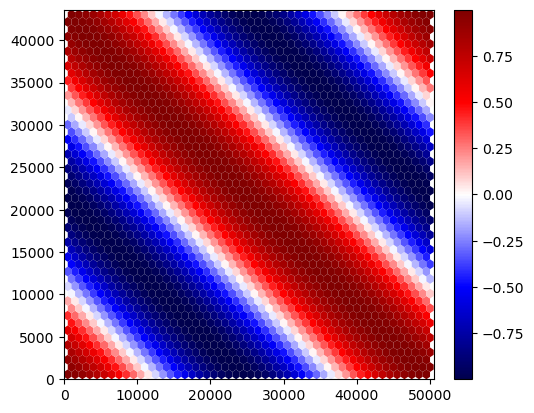

In [11]:
fig, ax, cbar, col = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Compare benchmarks with different threads per block
Initially, only threads per block of ssh calculation and update changes

In [12]:
function threadcount_test(; mpasOcean=mpasOcean, minblocksize=64, maxblocksize=1024, cases=8, periodicity="Periodic")
    threadcounts = []
    ttimes = []

    for blocksize::Integer in Int.(round.(range(minblocksize, maxblocksize, length=cases)))
        
        println("Now benchmarking with $blocksize threads per block.")
        
        bench = @benchmark forward_backward_step_cuda_threadcount!($mpasOcean; threadsCS=$blocksize, threadsUS=$blocksize)
        
        append!(threadcounts, [blocksize])
    
        append!(ttimes, [bench.times])

    end

    means = []
    for times in ttimes
        append!(means, mean(times))
    end

    stdevs = []
    for i in 1:length(ttimes)
        append!(stdevs, sqrt(mean( (ttimes[i] .- means[i]).^2 )) )
    end
    
    return threadcounts, ttimes, means, stdevs
end

threadcount_test (generic function with 1 method)

In [13]:
moveArrays!(mpasOcean, CUDA.CuArray)

In [14]:
threadcountsS, ttimesS, meansS, stdevsS = threadcount_test(mpasOcean=mpasOcean,
                                                            minblocksize=16, maxblocksize=1024, cases=32)

Now benchmarking with 16 threads per block.
Now benchmarking with 49 threads per block.
Now benchmarking with 81 threads per block.
Now benchmarking with 114 threads per block.
Now benchmarking with 146 threads per block.
Now benchmarking with 179 threads per block.
Now benchmarking with 211 threads per block.
Now benchmarking with 244 threads per block.
Now benchmarking with 276 threads per block.
Now benchmarking with 309 threads per block.
Now benchmarking with 341 threads per block.
Now benchmarking with 374 threads per block.
Now benchmarking with 406 threads per block.
Now benchmarking with 439 threads per block.
Now benchmarking with 471 threads per block.
Now benchmarking with 504 threads per block.
Now benchmarking with 536 threads per block.
Now benchmarking with 569 threads per block.
Now benchmarking with 601 threads per block.
Now benchmarking with 634 threads per block.
Now benchmarking with 666 threads per block.
Now benchmarking with 699 threads per block.
Now benchmark

(Any[16, 49, 81, 114, 146, 179, 211, 244, 276, 309  …  731, 764, 796, 829, 861, 894, 926, 959, 991, 1024], Any[[18496.0, 18681.0, 18689.0, 18705.0, 18727.0, 18734.0, 18734.0, 18752.0, 18755.0, 18758.0  …  274769.0, 277000.0, 281353.0, 281443.0, 282264.0, 283280.0, 291388.0, 297442.0, 4.143532e6, 4.198592e6], [19620.0, 19633.0, 19719.0, 19740.0, 19741.0, 19770.0, 19782.0, 19805.0, 19807.0, 19812.0  …  285179.0, 287170.0, 293621.0, 309245.0, 389559.0, 421565.0, 426372.0, 438390.0, 4.28765e6, 4.322847e6], [18660.0, 18741.0, 18743.0, 18746.0, 18748.0, 18761.0, 18780.0, 18792.0, 18792.0, 18802.0  …  278354.0, 282544.0, 282794.0, 284290.0, 284566.0, 284837.0, 289647.0, 417707.0, 4.203615e6, 4.212574e6], [18979.0, 18995.0, 19035.0, 19069.0, 19101.0, 19106.0, 19109.0, 19114.0, 19121.0, 19124.0  …  273064.0, 273131.0, 278250.0, 278504.0, 284519.0, 285809.0, 288528.0, 301449.0, 4.175488e6, 4.227528e6], [18932.0, 18945.0, 18987.0, 19011.0, 19027.0, 19032.0, 19033.0, 19037.0, 19041.0, 19047.0  …  

## Plot benchmarks against resolution

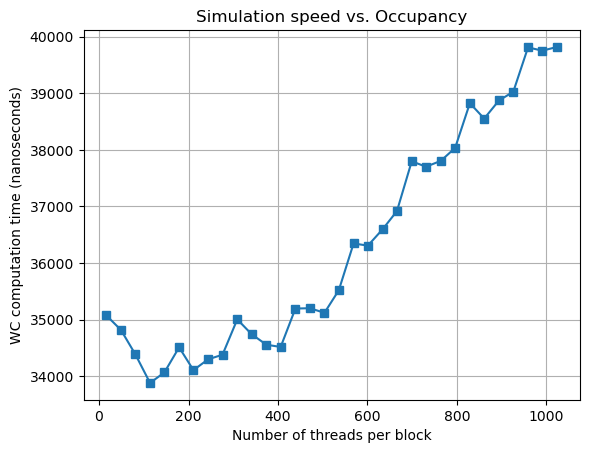

PyObject Text(0.5, 1.0, 'Simulation speed vs. Occupancy')

In [16]:
fig, ax = subplots(1,1)

# ax.set_xscale("log")
# ax.set_yscale("log")

plot(threadcountsS, meansS, marker="s") # yerr=stdevsC

ylabel("WC computation time (nanoseconds)")
xlabel("Number of threads per block")

# legend()

grid(which="both")

title("Simulation speed vs. Occupancy")

In [18]:
kernelnorm = CUDA.@cuda launch=false calculate_normal_velocity_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityTendency,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.cellsOnEdge,
                                                                        mpasOcean.nEdgesOnEdge,
                                                                        mpasOcean.edgesOnEdge,
                                                                        mpasOcean.weightsOnEdge,
                                                                        mpasOcean.fEdge,
                                                                        mpasOcean.dcEdge,
                                                                        mpasOcean.gravity)

CUDA.HostKernel{typeof(calculate_normal_velocity_tendency_cuda_kernel!), Tuple{Int64, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceMatrix{Int32, 1}, CUDA.CuDeviceVector{Int32, 1}, CUDA.CuDeviceMatrix{Int32, 1}, CUDA.CuDeviceMatrix{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, Float64}}(calculate_normal_velocity_tendency_cuda_kernel!, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8), CUDA.CuModule(Ptr{Nothing} @0x00000000083161a0, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8)), CUDA.CuFunction(Ptr{Nothing} @0x0000000008417af0, CUDA.CuModule(Ptr{Nothing} @0x00000000083161a0, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8))))

In [19]:
CUDA.launch_configuration(kernelnorm.fun)

(blocks = 20, threads = 1024)

In [20]:
CUDA.maxthreads(kernelnorm)

1024

In [21]:
threadcounts = collect(1:1:1024)

occupancies = collect([CUDA.occupancy(kernelnorm.fun, t) for t in threadcounts])

1024-element Vector{Float64}:
 0.015625
 0.03125
 0.046875
 0.0625
 0.078125
 0.09375
 0.109375
 0.125
 0.140625
 0.15625
 0.171875
 0.1875
 0.203125
 ⋮
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.5

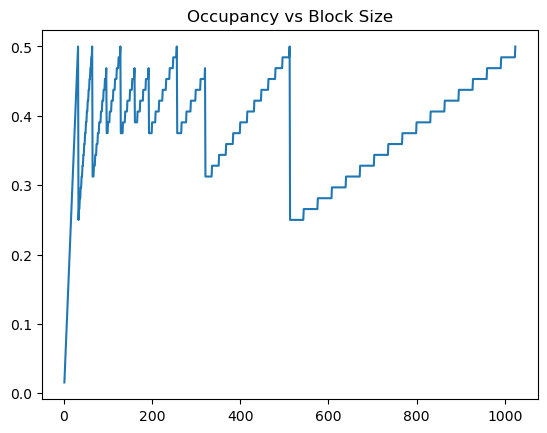

PyObject Text(0.5, 1.0, 'Occupancy vs Block Size')

In [24]:
plot(threadcounts, occupancies)

title("Occupancy vs Block Size")

In [21]:
CUDA.occupancy(kernelnorm.fun, 1)

0.015625

In [11]:
cld(mpasOcean.nEdges, 1024)

8

In [12]:
mpasOcean.nEdges/20

375.0